In [3]:
# Correr solo al empezar
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[*********************100%***********************]  1 of 1 completed


<ipython-input-5-ea79ae4fc2f7>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[colname] = round(df.Close.shift(-i),2)
<ipython-input-5-ea79ae4fc2f7>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PrecioAdvertencia_Pico'] = np.int64(df.Close.shift(-lags))


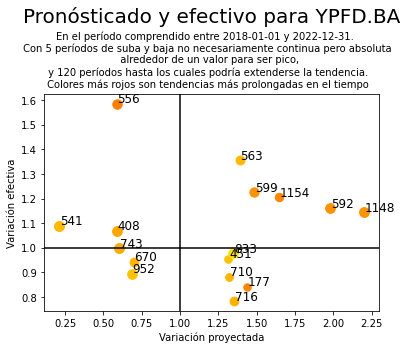

Cantidad de pronósticos: 16
Proporción de acertados: 0.5
Ganancia media en las ganancias: 0.16
Pérdida media en las pérdidas: -0.16
Resultado total: -0.05


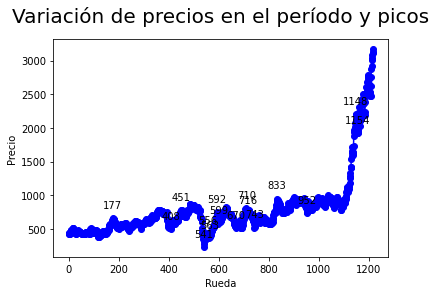

In [5]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# Parámetros a definir al inicio

lags = 5                                                                          # Cantidad de períodos hacia atrás y adelante que hacen falta para que sea considerado un quiebre
volMin = 0.7                                                                      # Percentil mínimo de volumen diario para validar el pico
maxDurTendencia = 120                                                             # Cantidad de períodos que podría extenderse una tendencia como máximo
ticker = "YPFD.BA"                                                                # Activo (En MERVAL, "ticker.BA", btc como "BTC-USD", el dolar es "USDARS=X" pero no corre bien porque no tiene volumen)
startDate = "2018-01-01"                                                          # Fecha de inicio
endDate = "2022-12-31"                                                            # Fecha de cierre
varMin = 0.30                                                                     # Variación proyectada mínima para validar operación

# Descarga de históricos

df = yf.download(ticker, start=startDate, end=endDate)
df['VolumePerc'] = pd.qcut(df.Volume, 100, labels=False, duplicates='drop')
df['Rueda'] = np.arange(len(df))
df = df[['Rueda', 'Close', 'VolumePerc']]

# Construcción de variables y picos

i = 1
while i < (lags+1):
    colname = 'p%sb' % (i)                                                  
    df[colname] = round(df.Close.shift(i),2)
    j = i * -1
    colname = 'p%sf' % (-j)                                                  
    df[colname] = round(df.Close.shift(j),2)
    i = i + 1

df['maxb'] = round(df.filter(regex=(".*b")).max(axis=1),2)
df['maxf']= round(df.filter(regex=(".*f")).max(axis=1),2)
df['minb'] = round(df.filter(regex=(".*b")).min(axis=1),2)
df['minf'] = round(df.filter(regex=(".*f")).min(axis=1),2)
df['techo'] = np.where((df['Close']>df['maxb']) & (df['Close']>df['maxf']), 1, 0)
df['piso'] = np.where((df['Close']<df['minb']) & (df['Close']<df['minf']), 1, 0)
i=1
while i < maxDurTendencia:
    colname = 'pr%sf' % (i)                                                  
    df[colname] = round(df.Close.shift(-i),2)
    i = i + 1
df['PrecioAdvertencia_Pico'] = np.int64(df.Close.shift(-lags))

# Armo las proyecciones de los picos en caso de que la tendencia no se rompa

techos = df[(df['techo']==1)]
techos['PicoAnterior_Rueda'] = np.int64(techos.Rueda.shift(1))
techos['PicoAnterior_Close'] = techos.Close.shift(1)
techos['PicoAnterior_Variación'] = techos.Close/techos.PicoAnterior_Close
techos['PicoProyectado_Precio'] = techos.Close*techos.PicoAnterior_Variación
techos['PicoProyectado_Rueda'] = techos.Rueda+(techos.Rueda-techos.PicoAnterior_Rueda)
techos['PicoProyectado_Lags'] = techos.Rueda-techos.PicoAnterior_Rueda
techos['PicoProyectado_Columna'] = 'pr' + techos.PicoProyectado_Lags.astype(str) + 'f'
pisos = df[(df['piso']==1)]
pisos['PicoAnterior_Rueda'] = np.int64(pisos.Rueda.shift(1))
pisos['PicoAnterior_Close'] = pisos.Close.shift(1)
pisos['PicoAnterior_Variación'] = pisos.Close/pisos.PicoAnterior_Close
pisos['PicoProyectado_Precio'] = pisos.Close*pisos.PicoAnterior_Variación
pisos['PicoProyectado_Rueda'] = pisos.Rueda+(pisos.Rueda-pisos.PicoAnterior_Rueda)
pisos['PicoProyectado_Lags'] = pisos.Rueda-pisos.PicoAnterior_Rueda
pisos['PicoProyectado_Columna'] = 'pr' + pisos.PicoProyectado_Lags.astype(str) + 'f'
picos = pd.concat([techos, pisos])

# Comparo con las efectivas

dfForwards = df.loc[:,(df.columns.str.startswith("pr"))|(df.columns.str.startswith("Rueda"))]
dfForwards = dfForwards.melt(id_vars=['Rueda'], var_name='lags', value_name='precio')
picosForwards = picos.merge(dfForwards, how='left', left_on=['Rueda', 'PicoProyectado_Columna'], right_on=['Rueda', 'lags'])
picosForwards['VariacionProyectada'] = picosForwards.PicoProyectado_Precio/picosForwards.PrecioAdvertencia_Pico
picosForwards['VariacionEfectiva'] = picosForwards.precio/picosForwards.PrecioAdvertencia_Pico
picosForwards = picosForwards[picosForwards.PicoProyectado_Lags <= maxDurTendencia]
picosForwards = picosForwards[['Rueda', 'PicoProyectado_Lags', 'VolumePerc', 'VariacionProyectada', 'VariacionEfectiva']]
picosForwards = picosForwards[(picosForwards.VolumePerc >= volMin)]
picosForwards = picosForwards[(picosForwards.VariacionProyectada > (1+varMin))|(picosForwards.VariacionProyectada < (1-varMin))]

picosForwards.loc[picosForwards['VariacionProyectada'] > 1, 'Resultado'] = picosForwards.VariacionEfectiva - 1
picosForwards.loc[picosForwards['VariacionProyectada'] < 1, 'Resultado'] = 1 - picosForwards.VariacionEfectiva

# Grafico

picosForwards = picosForwards.dropna().reset_index(drop=True)
types = picosForwards.Rueda
x_coords = picosForwards.VariacionProyectada
y_coords = picosForwards.VariacionEfectiva
c_coords = picosForwards.PicoProyectado_Lags/picosForwards.PicoProyectado_Lags.max()
sizes = picosForwards.VolumePerc
for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    col = c_coords[i]
    size = sizes[i]
    plt.scatter(x, y, c=col, s=size, cmap="Wistia", vmin=0, vmax=1)
    plt.text(x+0.005, y+0.005, type, fontsize=12)
plt.axhline(y=1,color='k', linestyle='-')
plt.axvline(x=1,color='k', linestyle='-')
plt.xlabel('Variación proyectada')
plt.ylabel('Variación efectiva')
plt.title('Pronósticado y efectivo para {}'.format(ticker), fontsize=20).set_position([0.5, 1.3])
plt.suptitle('En el período comprendido entre {} y {}. \n Con {} períodos de suba y baja no necesariamente continua pero absoluta\n  alrededor de un valor para ser pico,\n y {} períodos hasta los cuales podría extenderse la tendencia.\n Colores más rojos son tendencias más prolongadas en el tiempo'.format(startDate, endDate, lags, maxDurTendencia).format(ticker), y=1.1, fontsize=10)    
plt.show()

totales = picosForwards.Resultado.count()
resultadoTotal = round(picosForwards.Resultado.sum(),2)
acertados = picosForwards.Resultado[picosForwards.Resultado > 0].count()
mediaGanancia = round(picosForwards.Resultado[picosForwards.Resultado > 0].mean(),2)
equivocados = picosForwards.Resultado[picosForwards.Resultado < 0].count()
mediaPerdida = round(picosForwards.Resultado[picosForwards.Resultado < 0].mean(),2)
proporción = round(acertados/(acertados+equivocados),2)

print("Cantidad de pronósticos: {}".format(totales))
print("Proporción de acertados: {}".format(proporción))
print("Ganancia media en las ganancias: {}".format(mediaGanancia))
print("Pérdida media en las pérdidas: {}".format(mediaPerdida))
print("Resultado total: {}".format(resultadoTotal))

dfplot = df[df.Rueda.isin(picosForwards.Rueda)]
xs = df.Rueda
ys = df.Close
xn = dfplot.Rueda
yn = dfplot.Close
plt.plot(xs,ys,'bo-')
for x,y in zip(xn,yn):
    plt.annotate(x, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.xlabel('Rueda')
plt.ylabel('Precio')
plt.title('Variación de precios en el período y picos'.format(ticker), fontsize=20).set_position([0.5, 1.05])

# TO DO
# La tabla picos debería recortarse con lo que haría falta para sacar las figuras probables a partir de eso
# Ver por qué si armo las proyecciones de los picos en caso de que la tendencia no se rompa pero armo tendencia del pico anterior al siguiente (sea cual sea) da tan bien contra la tendencia, sería picos = df[(df['techo']==1)|(df['piso']==1)]